# Comparison of the perfomance on synthetic data from a sphere and a cube

This notebook compares the performance of the proposed method on synthetic data produced by a sphere with the data produced by a cube. Both synthetic bodies are uniformly magnetized with the same magnetization vector. The centers of both bodies are located at the same point. The radius of the sphere is equal to the side length of the cube.

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries and define some functions needed for error propagation.

The 3 lines of code below must be executed if you are running on Windows (see [the neurovisio docs](https://neuronvisio.readthedocs.org/en/latest/gettingstarted.html#troubleshooting) and [the IPython docs](http://ipython.org/ipython-doc/dev/interactive/reference.html#pyqt-and-pyside) for more information).

In [1]:
import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
%matplotlib inline
import numpy
import scipy
from scipy import sparse
from IPython.display import Image
import fatiando
from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, prism, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, contaminate
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir
mpl.rc('font', size=11)

In [3]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [2]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = numpy.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*H.dot(H.T)))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

def uncertainty_L2(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L2 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*numpy.linalg.inv(solver.jacobian(p=None).T.dot(solver.jacobian(p=None)))))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh


## Define the center of the bodies, computation grid, geomagnetic field direction, and magnetization

The radius of the sphere and the side length of the cube are equal to $R$. The center of these two synthetic bodies are located at the same Cartesian coordinates $(X_{0}, Y_{0}, Z_{0})$

In [3]:
X0 = 0.0    # x coordinate of the center of the synthetic bodies
Y0 = 0.0    # y coordinate of the center of the synthetic bodies
Z0 = 2000.0 # z coordinate of the center of the synthetic bodies

center = [[X0, Y0, Z0]]

R = Z0      # radius of the sphere and side length of the cube

The total-field anomalies produced by the synthetic bodies are calculated on a regular grid with constant vertical coordinate $z_{0} = -150 \, m$, extending from $-10000 \, m$ to $10000 \, m$ along the horizontal directions $x$ and $y$

In [4]:
area = [-10000, 10000, -10000, 10000]
bounds = area + [0.0, 3*R]
shape = (100,100)
z0 = -150
x, y, z = gridder.regular(area, shape, z=z0)

Specify the total magnetization direction of the two bodies and the geomagnetic field. The two synthetic bodies have the same reversed magnetization.

In [5]:
inc, dec = 9.5, 13.0 # inclination and declination of the Geomagnetic Field
incs, decs = -inc, dec-180 # inclination and declination of the magnetization vector of the synthetic bodies (reversed)
ints = 3.5 # intensity of the magnetization vector of the synthetic bodies

The total-field anomalies produced by the synthetic bodies will be corrupted with a pseudo-random Gaussian noise of null mean and standard deviation $5 \, nT$.

In [6]:
uncertainty_data = 5.0 # nT

## Results for the sphere

Define the sphere and calculate the noise-currupted total field magnetic anomaly.

In [7]:
sphere = [mesher.Sphere(X0, Y0, Z0, R, {'magnetization': ang2vec(ints, incs, decs)})]

# Noise-corrupted total-field anomaly produced by the synthetic sphere
tf = contaminate(gravmag.sphere.tf(x, y, z, sphere, inc, dec), uncertainty_data)

Plot the calculated anomaly.

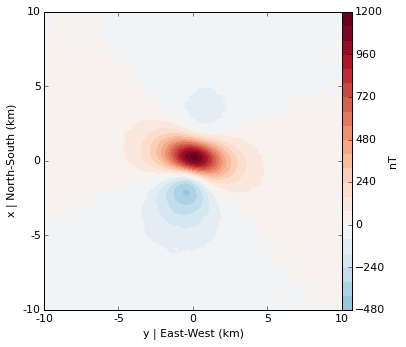

In [19]:
mpl.figure(figsize=(6, 5))
mpl.axis('scaled')
scale = max(abs(tf.min()), abs(tf.max()))
mpl.contourf(y, x, tf, shape, 20, vmin=-scale, vmax=scale, cmap=mpl.cm.RdBu_r)
mpl.colorbar(pad=0, aspect=30).set_label('nT')
mpl.m2km()
mpl.xlabel('y | East-West (km)')
mpl.ylabel('x | North-South (km)')
mpl.tight_layout()

Plot the sphere (transparent blue) and its center (black sphere).

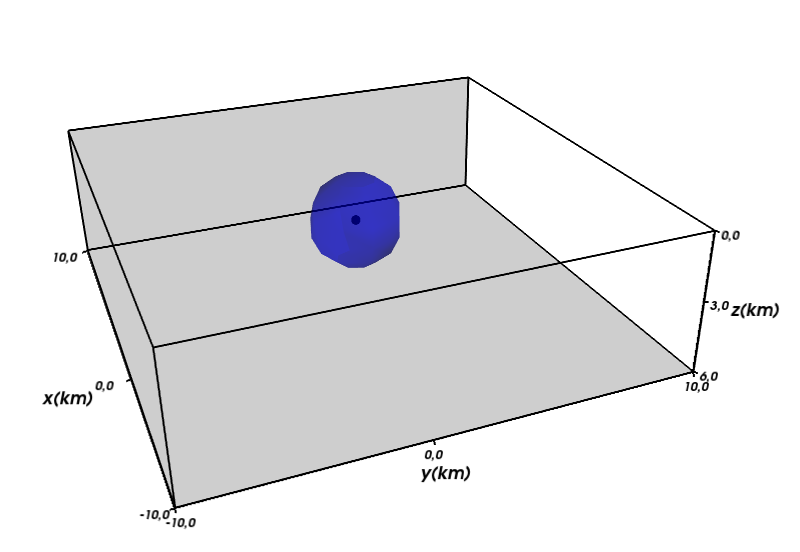

In [23]:
scene = myv.figure(size=(800, 600))
myv.points(center, color=(0, 0, 1), size=R, opacity=0.5)
myv.points(center, color=(0, 0, 0), size=0.1*R, opacity=1)
ax = myv.axes(myv.outline(extent=bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.1f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_north(bounds)
myv.wall_bottom(bounds)
scene.scene.camera.position = [-36343.850932310721, -13160.083746481647, -15883.487014961409]
scene.scene.camera.focal_point = [-1641.0924100826185, 1279.9382127516797, 4078.3399428708144]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.43100103273893786, 0.18508739696338428, -0.8831651970403317]
scene.scene.camera.clipping_range = [16748.90795933198, 76051.460310248425]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('sphere.png')
myv.show()
Image(filename='sphere.png')

Next, we apply of our method to estimate the magnetization direction using both the L2 and L1 norm inversions.

In [24]:
# Estimate the magnetization vector with the L2 approach
solver_L2 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()
for i in range(100):
    w = numpy.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

Print the estimated and true inclination and declination for both inversions.

In [25]:
print 'Comparison between True and Estimated parameters'
print 'Inclination (first column) and Declination (second column)'
print 'True'
for i in range(solver_L1.ndipoles):
    print '%12.5f %12.5f' % (incs, decs)
print 'Estimated L2'
for e in solver_L2.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L2'
for dhj in dh_L2:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])
print 'Estimated L1'
for e in solver_L1.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L1'
for dhj in dh_L1:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

Comparison between True and Estimated parameters
Inclination (first column) and Declination (second column)
True
    -9.50000   -167.00000
Estimated L2
    -9.51240   -166.99114
Uncertainties L2
     0.00036      0.00069
Estimated L1
    -9.50410   -167.00773
Uncertainties L1
     0.01629      0.02089


Now we'll plot the fit (observed versus predicted anomalies) for both inversions. We'll also show the normalized histogram of the residuals. 

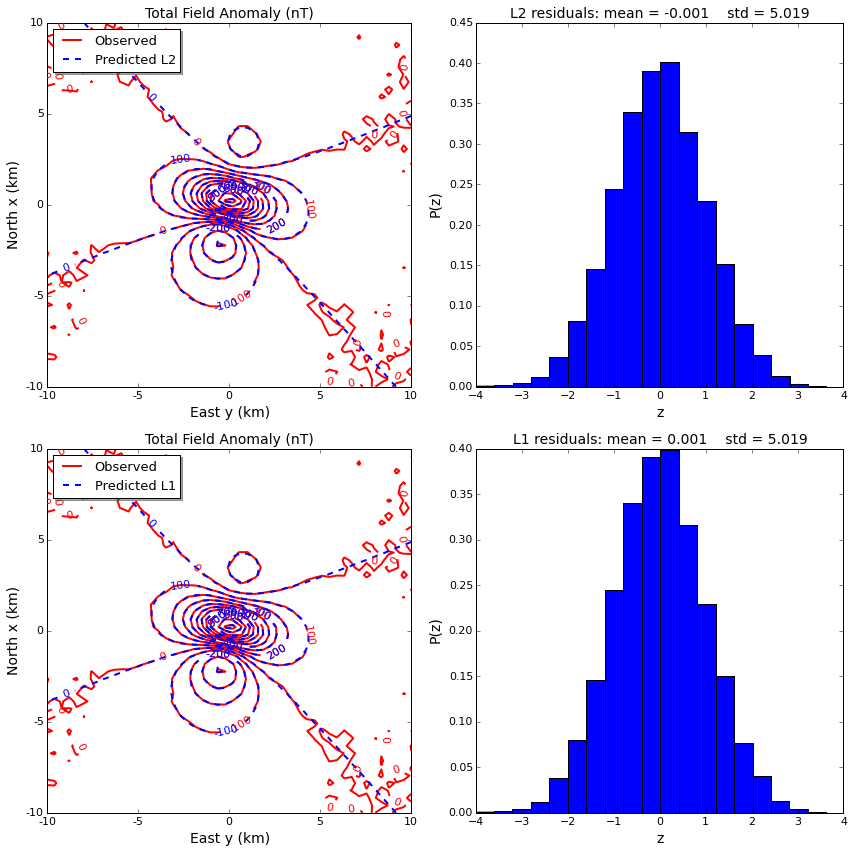

In [30]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(12, 12))
mpl.subplot(2, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted L2', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 2, 2)
residuals_mean = numpy.mean(solver_L2.residuals())
residuals_std = numpy.std(solver_L2.residuals())
# Each residual is subtracted from the mean and the resulting 
# difference is divided by the standard deviation
s = (solver_L2.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("L2 residuals: mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), 
                                                       fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.subplot(2, 2, 3)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted L1', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 2, 4)
residuals_mean = numpy.mean(solver_L1.residuals())
residuals_std = numpy.std(solver_L1.residuals())
# Each residual is subtracted from the mean and the resulting 
# difference is divided by the standard deviation
s = (solver_L1.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("L1 residuals: mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), 
                                                       fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.tight_layout()

The figure above shows the observed data (the noise-corrupted data produced by the synthetic sphere) in red lines and the predicted data (in dashed blue lines) obtained by inversion with L1- and L2-norm approaches.

## Results for the cube

We'll now run the inversion on synthetic data from a cube with the same center as the sphere. The side length of the cube is the same as the radius of the sphere.

First, we define the prism and calculate the noise-corrupted total field anomaly.

In [31]:
prism = [mesher.Prism(X0-R, X0+R, Y0-R, Y0+R, Z0-R, Z0+R, {'magnetization': ang2vec(3.5, incs, decs)})]

# Noise-corrupted total-field anomaly produced by the synthetic cube
tf = contaminate(gravmag.prism.tf(x, y, z, prism, inc, dec), uncertainty_data)

Plot the anomaly of the prism. Notice that the anomaly is very different from that of the sphere and presents strongly non-dipolar features.

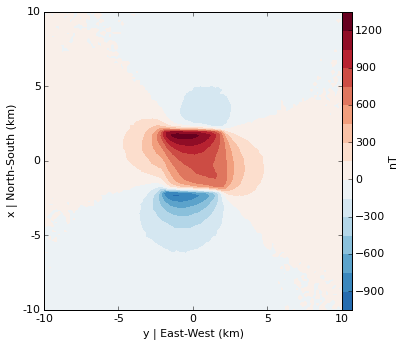

In [32]:
mpl.figure(figsize=(6, 5))
mpl.axis('scaled')
scale = max(abs(tf.min()), abs(tf.max()))
mpl.contourf(y, x, tf, shape, 20, vmin=-scale, vmax=scale, cmap=mpl.cm.RdBu_r)
mpl.colorbar(pad=0, aspect=30).set_label('nT')
mpl.m2km()
mpl.xlabel('y | East-West (km)')
mpl.ylabel('x | North-South (km)')
mpl.tight_layout()

Plot the cube (transparent blue) and the center of the cube (black sphere).

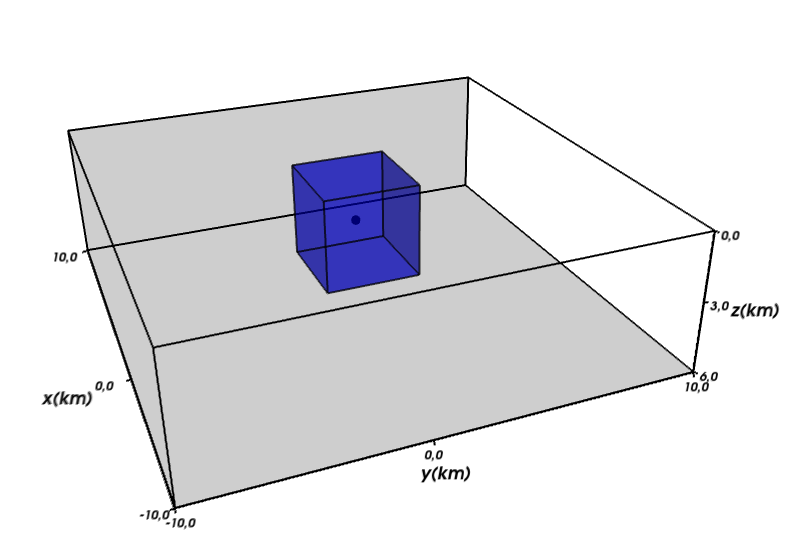

In [33]:
# Plot the synthetic body
scene = myv.figure(size=(800, 600))
#myv.points(center, color=(0, 0, 1), size=R, opacity=0.5)
myv.prisms(prism, opacity=0.5, color=(0, 0, 1), linewidth=2.0)
myv.points(center, color=(0, 0, 0), size=0.1*R, opacity=1)
ax = myv.axes(myv.outline(extent=bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.1f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_north(bounds)
myv.wall_bottom(bounds)
scene.scene.camera.position = [-36343.850932310721, -13160.083746481647, -15883.487014961409]
scene.scene.camera.focal_point = [-1641.0924100826185, 1279.9382127516797, 4078.3399428708144]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.43100103273893786, 0.18508739696338428, -0.8831651970403317]
scene.scene.camera.clipping_range = [16748.90795933198, 76051.460310248425]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('cube.png')
myv.show()
Image(filename='cube.png')

Next, we apply our method to estimate the magnetization direction of the synthetic cube using the L2 and L1 inversions.

In [34]:
# Estimate the magnetization vector with the L2 approach
solver_L2 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()
for i in range(100):
    w = numpy.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

Print the estimated results and the true values.

In [35]:
# Print the estimated and true inclination and declination
print 'Comparison between True and Estimated parameters'
print 'Inclination (first column) and Declination (second column)'
print 'True'
for i in range(solver_L1.ndipoles):
    print '%12.5f %12.5f' % (incs, decs)
print 'Estimated L2'
for e in solver_L2.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L2'
for dhj in dh_L2:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])
print 'Estimated L1'
for e in solver_L1.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L1'
for dhj in dh_L1:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

Comparison between True and Estimated parameters
Inclination (first column) and Declination (second column)
True
    -9.50000   -167.00000
Estimated L2
    -9.59277   -164.63005
Uncertainties L2
     0.00026      0.00049
Estimated L1
    -9.01132   -167.44002
Uncertainties L1
     0.01473      0.04016


The results above show that our method is able to retrieve the true magnetization direction of the synthetic bodies, even if the synthetic data are produced by a non-spherical source such as a cube.

For completeness, we'll plot the observed and predicted data for the L1 and L2 norm inversions.

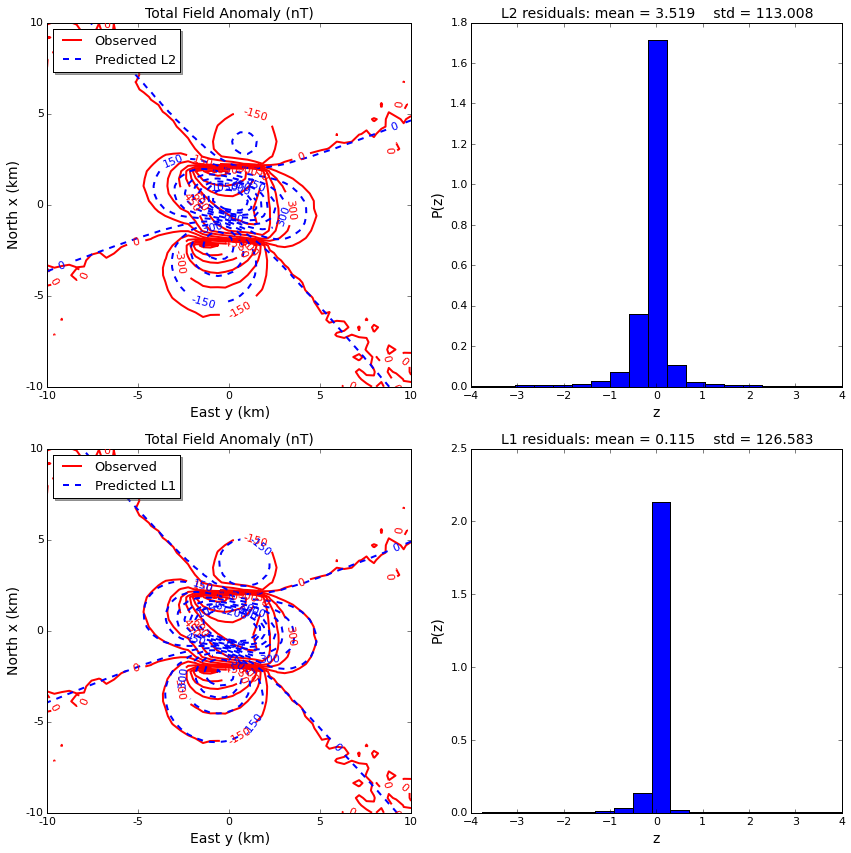

In [36]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(12, 12))
mpl.subplot(2, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted L2', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 2, 2)
residuals_mean = numpy.mean(solver_L2.residuals())
residuals_std = numpy.std(solver_L2.residuals())
# Each residual is subtracted from the mean and the resulting 
# difference is divided by the standard deviation
s = (solver_L2.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("L2 residuals: mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), 
                                                       fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.subplot(2, 2, 3)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted L1', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 2, 4)
residuals_mean = numpy.mean(solver_L1.residuals())
residuals_std = numpy.std(solver_L1.residuals())
# Each residual is subtracted from the mean and the resulting 
# difference is divided by the standard deviation
s = (solver_L1.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("L1 residuals: mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), 
                                                       fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.tight_layout()

The figure above shows the observed data (the noise-corrupted data produced by the synthetic cube) in red lines and the predicted data (in dashed blue lines) obtained by inversion with L1- and L2-norm approaches.